# Let's Play Moneyball
## Welcome to Week 2!

This week we'll be exploring the FIFA 2019 dataset, and seeing how we can use one of the most popular algorithms in data science and machine learning - Linear Regression - to make us millions of dollars. Even if sports is not your thing, this is a good lesson in excercising your curiosity. 

Your task will be to find the variables to predict strikers so our team can hire the best player, without spending too much money. We need to know who is undervalued, who is overvalued, and what variables create a great player. Let's get started!

In [16]:
import numpy as np   
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
from matplotlib import pyplot as plt

# Set the default size for all figures (graphs) to be 16 inches across by 8 inches high
plt.rcParams["figure.figsize"] = (16,8)

# Set the style for all graphs (more options can be found: https://python-graph-gallery.com/104-seaborn-themes/)
sns.set_style('whitegrid')

# You can also set the style using matplotlib. Options can be found at: https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
# To use the ggplot style, for example, you would use this line of code instead:
# plt.style.use('ggplot')

We can download our dataset from the git repository. It's a bit slower, but you don't need to have a local copy. If you want to download the data and store it locally, you can do so at https://www.kaggle.com/karangadiya/fifa19

In [4]:
fifa_df = pd.read_csv("https://github.com/rucogsciclub/Data_Science_Bootcamp/raw/master/Week_2/data/fifadata.csv")

To get a sense of what we're working with, we can use the ```.info()``` function to see all our columns and their datatypes. We can look at the first 10 rows of our dataset by using ```fifa_df.head(10)```

In [5]:
print(fifa_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
Unnamed: 0                  18207 non-null int64
ID                          18207 non-null int64
Name                        18207 non-null object
Age                         18207 non-null int64
Photo                       18207 non-null object
Nationality                 18207 non-null object
Flag                        18207 non-null object
Overall                     18207 non-null int64
Potential                   18207 non-null int64
Club                        17966 non-null object
Club Logo                   18207 non-null object
Value                       18207 non-null object
Wage                        18207 non-null object
Special                     18207 non-null int64
Preferred Foot              18159 non-null object
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null fl

In [6]:
print(fifa_df.head(10))

   Unnamed: 0      ID               Name  Age  \
0           0  158023           L. Messi   31   
1           1   20801  Cristiano Ronaldo   33   
2           2  190871          Neymar Jr   26   
3           3  193080             De Gea   27   
4           4  192985       K. De Bruyne   27   
5           5  183277          E. Hazard   27   
6           6  177003          L. Modrić   32   
7           7  176580          L. Suárez   31   
8           8  155862       Sergio Ramos   32   
9           9  200389           J. Oblak   25   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   
5  https://cdn.sofifa.org/players/4/19/183277.png     Belgium   
6  ht

# Cleaning up the data

You'll see there are some portions of our data that need to be cleaned up a bit before we ues it. Release Clause, for example, still contains Euro signs - if we want to treat it as a raw number we'll need to do a bit of data cleaning.

Cleaning data is not the focus of today's lesson, so take us on our word that this works. You can just run these cells in order and your data set will be easier to work with as a result.

In [7]:
features = ['Acceleration','SprintSpeed','Agility', 'Stamina','Strength', 'Height', 'Finishing']
target = 'Value'

In [8]:
'''
Helper Functions to clean the data:
'''
def height_to_inches(h):
  if type(h) is str:
    hsplit = h.split("'")   # splits a string like 5'7 and returns the total inches
    feet = int(hsplit[0])
    inches = int(hsplit[1])
    return feet*12 + inches
  else:
    return h

def clean_weight(w):
  if type(w) is str:
    wnew = int(w.replace("lbs",""))
    return wnew
  else:
    return w

def clean_price(c):
  if type(c) is str:
    ismillion = False
    if "M" in c:
      ismillion = True
    cnew = float(c.replace("€", "").replace("M", "").replace("K", ""))
    if ismillion:
      cnew *= 1000000
    return cnew
  else:
    return c


# Getting rid of NA values
all_cols = [i for i in features]
all_cols.append(target)
cols_to_keep = [not i for i in fifa_df[all_cols].isna().any(axis=1)]
fifa_df = fifa_df[cols_to_keep]

# Clean up height - convert it from a string to an int
fifa_df['Height'] = fifa_df['Height'].apply(height_to_inches)
fifa_df['Height'].astype('int')

# Convert wieght from a string to an int
fifa_df['Weight'] = fifa_df['Weight'].apply(clean_weight)
fifa_df['Weight'].astype('int')

# We're not using these features (Value and Release Clause) in our current example,
# However, if you wanted to use them you could run the commented out code below 
# to clean them up a bit.
'''
print(fifa_df['Value'])
fifa_df['Value'] = fifa_df['Value'].apply(clean_price)
fifa_df['Value'].astype('int')
print(fifa_df['Value'])

print(fifa_df['Release Clause'])
fifa_df['Release Clause'] = fifa_df['Release Clause'].apply(clean_price)
fifa_df['Release Clause'].astype('int')
print(fifa_df['Release Clause'])
'''

# Applying cleanup to the target as well
fifa_df['Value'] = fifa_df['Value'].apply(clean_price)
fifa_df['Value'].astype('int')

# Now we can look at how those modifications changed our features / target!
print(fifa_df[features + [target]].head(10))

   Acceleration  SprintSpeed  Agility  Stamina  Strength  Height  Finishing  \
0          91.0         86.0     91.0     72.0      59.0      67       95.0   
1          89.0         91.0     87.0     88.0      79.0      74       94.0   
2          94.0         90.0     96.0     81.0      49.0      69       87.0   
3          57.0         58.0     60.0     43.0      64.0      76       13.0   
4          78.0         76.0     79.0     90.0      75.0      71       82.0   
5          94.0         88.0     95.0     83.0      66.0      68       84.0   
6          80.0         72.0     93.0     89.0      58.0      68       72.0   
7          86.0         75.0     82.0     90.0      83.0      72       93.0   
8          76.0         75.0     78.0     84.0      83.0      72       60.0   
9          43.0         60.0     67.0     41.0      78.0      74       11.0   

         Value  
0  110500000.0  
1   77000000.0  
2  118500000.0  
3   72000000.0  
4  102000000.0  
5   93000000.0  
6   6700000

# EDA - Exploratory Data Analysis
As we learned last week, Exploratory Data Analysis is a central component to any data science project. Our goal is to get a sense for the underlying distributions of our variables. In the next few cells, we'll walk through some plots that accomplish that goal.

This is a good refresher from last week as well, in a more applied setting.

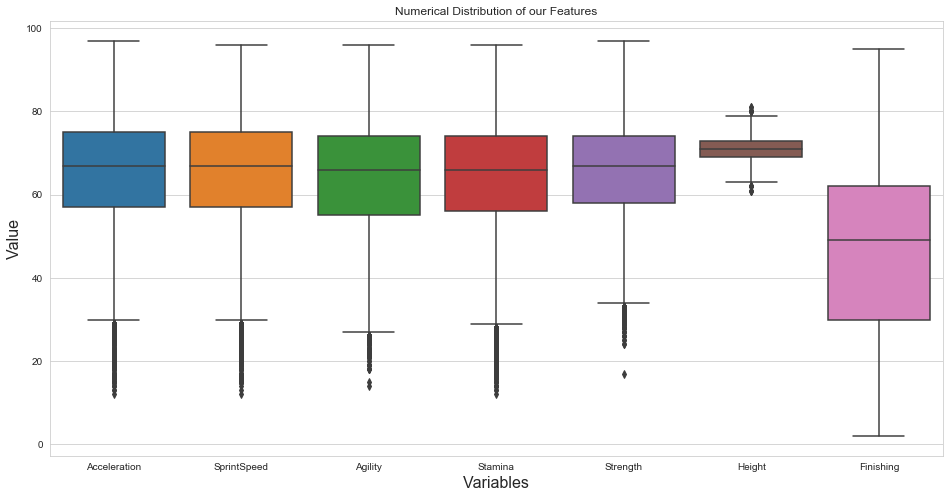

In [17]:
fig = plt.figure()   # Create a figure

X = fifa_df[features]
sns.boxplot(x="variable", y="value", data=pd.melt(X))

plt.title('Numerical Distribution of our Features')
plt.xlabel('Variables', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.show()

# But we only care about Strikers 
Let's filter our dataset to get rid of all other players besides strikers, and see if that changes any of our distributions.

In [10]:
strikers = fifa_df[fifa_df['Position'] == 'ST']
strikers

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
10,10,188545,R. Lewandowski,29,https://cdn.sofifa.org/players/4/19/188545.png,Poland,https://cdn.sofifa.org/flags/37.png,90,90,FC Bayern München,...,86.0,34.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0,€127.1M
16,16,202126,H. Kane,24,https://cdn.sofifa.org/players/4/19/202126.png,England,https://cdn.sofifa.org/flags/14.png,89,91,Tottenham Hotspur,...,89.0,56.0,36.0,38.0,8.0,10.0,11.0,14.0,11.0,€160.7M
23,23,153079,S. Agüero,30,https://cdn.sofifa.org/players/4/19/153079.png,Argentina,https://cdn.sofifa.org/flags/52.png,89,89,Manchester City,...,90.0,30.0,20.0,12.0,13.0,15.0,6.0,11.0,14.0,€119.3M
36,36,173731,G. Bale,28,https://cdn.sofifa.org/players/4/19/173731.png,Wales,https://cdn.sofifa.org/flags/50.png,88,88,Real Madrid,...,86.0,54.0,55.0,52.0,15.0,15.0,11.0,5.0,6.0,€123M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18177,18177,238550,R. Roache,18,https://cdn.sofifa.org/players/4/19/238550.png,Republic of Ireland,https://cdn.sofifa.org/flags/25.png,48,69,Blackpool,...,49.0,18.0,16.0,11.0,6.0,9.0,11.0,7.0,12.0,€193K
18189,18189,240160,A. Kaltner,18,https://cdn.sofifa.org/players/4/19/240160.png,Germany,https://cdn.sofifa.org/flags/21.png,47,61,SpVgg Unterhaching,...,37.0,28.0,15.0,22.0,15.0,5.0,14.0,12.0,8.0,€125K
18200,18200,231381,J. Young,18,https://cdn.sofifa.org/players/4/19/231381.png,Scotland,https://cdn.sofifa.org/flags/42.png,47,62,Swindon Town,...,50.0,15.0,17.0,14.0,11.0,15.0,12.0,12.0,11.0,€143K
18203,18203,243165,N. Christoffersson,19,https://cdn.sofifa.org/players/4/19/243165.png,Sweden,https://cdn.sofifa.org/flags/46.png,47,63,Trelleborgs FF,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K


Now let's plot both figures side by side so we can see what's changed.

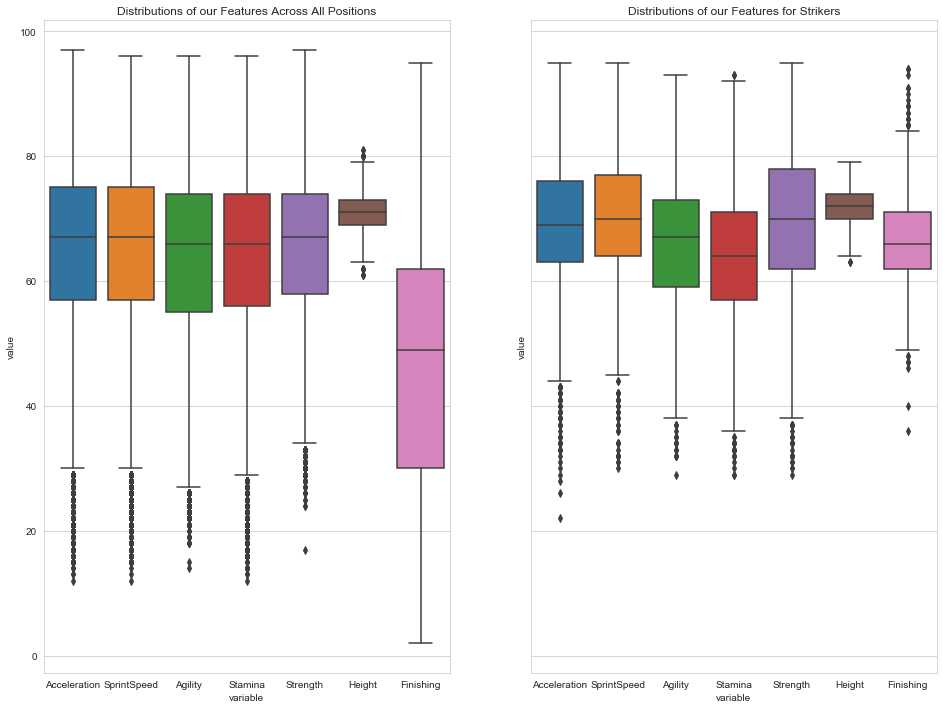

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,12))    # This specifies that we want one row of plots with two columns.

X_all = fifa_df[features]
sns.boxplot(x='variable', y='value', ax=ax1, data=pd.melt(X_all))   # Let's put all players in the first column

X_strike = strikers[features]
sns.boxplot(x='variable', y='value', ax=ax2, data=pd.melt(X_strike)) # And see just strikers in the second

ax1.set_title('Distributions of our Features Across All Positions')
ax2.set_title('Distributions of our Features for Strikers')

plt.show()

# Additional Filtering

We only want the cream of the crop, so let's do a bit more data cleaning to try and weed out the best strikers.

We can filter our data so we only get the fastest strikers by sprinting and acceleration, the strongest, and most frequent finishers. Importantly, we can also filter the Value so we only get strikers below a certain price. Here we'll use 50 million, but you may want to mess around with better heuristics (ie; players whose values are no more than a standard deviation above the average).

In [19]:
best_strikers = strikers.where((strikers['SprintSpeed'] > 80) 
                               & (strikers['Acceleration'] > 80)
                               & (strikers['Strength'] > 70) 
                               & (strikers['Finishing'] > 70)
                               & (strikers['Value'] < 50000000)).dropna(how='all')

print(best_strikers.shape[0], 'Rows, ', best_strikers.shape[1], 'Columns')

27 Rows,  89 Columns


# Now, we can finally perform Linear Regression on our final candidates

To start, we'll look at how the overall performance of our players varies based on their finishing scores.

In [20]:
X = best_strikers['Finishing']
y = best_strikers['Overall']

In [21]:
x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     42.93
Date:                Tue, 25 Feb 2020   Prob (F-statistic):           7.29e-07
Time:                        21:23:42   Log-Likelihood:                -61.006
No. Observations:                  27   AIC:                             126.0
Df Residuals:                      25   BIC:                             128.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.4074      8.678      2.352      0.0

/Users/yoni/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


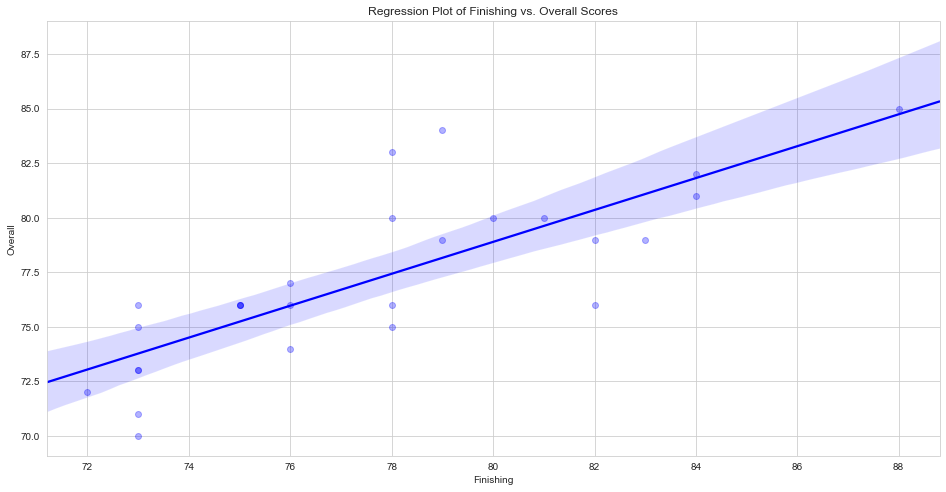

In [22]:
fig = plt.figure()

plt.title('Regression Plot of Finishing vs. Overall Scores')
sns.regplot(X, y, color='blue', scatter_kws={'alpha':0.3})

plt.show()

Let's plot our residuals (our errors) to see if our model makes sense. We expect to see residuals normally distributed about the mean.

Residuals: 
87      0.260690
124     5.840089
193     5.571133
268     0.184867
381    -0.815133
430     0.378000
479     2.571133
518     1.109045
560     0.840089
561    -1.353044
653    -2.084088
1022    1.033222
1216    2.226355
1226   -1.428867
1237    0.764266
1347    0.764266
1386    0.033222
1404    0.764266
1507   -4.353044
2023    1.226355
2029   -2.428867
2253   -1.966778
2936   -0.773645
3210   -0.773645
3665   -1.042601
4519   -2.773645
5523   -3.773645
dtype: float64




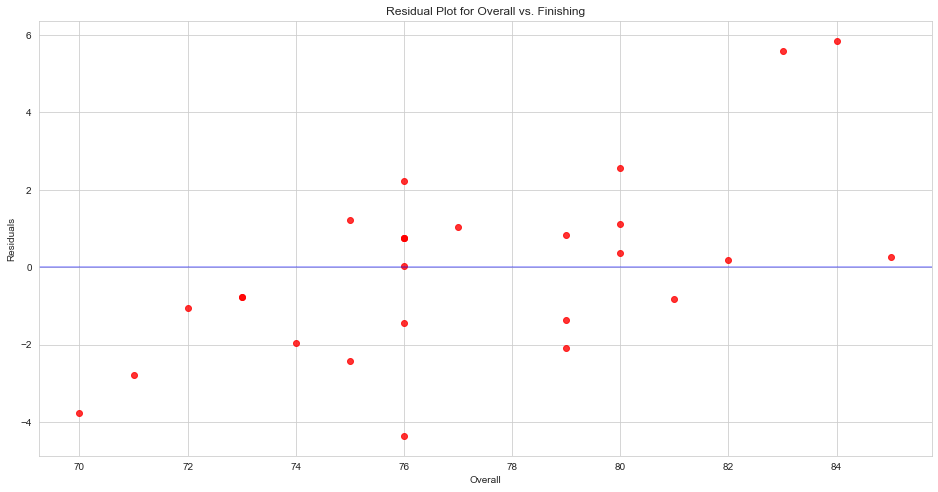

In [23]:
residuals = results.resid
print('Residuals: \n' + str(residuals) + '\n\n')

fig = plt.figure()
plt.scatter(y, residuals, color='red', alpha=0.8)
plt.axhline(y=0, color='b', linestyle='-', alpha=0.4)   # Horizontal line centered at 0

plt.xlabel('Overall')
plt.ylabel('Residuals')
plt.title('Residual Plot for Overall vs. Finishing')
plt.show()

# Your turn! 

### Pick a feature that you think would be a good predictor of Overall score for a player. 

If you have any questions, ask away!

In [194]:
X = # ... FILL THIS LINE IN
y = # ... FILL THIS LINE IN
x = sm.add_constant(X)

## Build a model to test your predictions

In [163]:
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Value   R-squared (uncentered):                   0.832
Model:                            OLS   Adj. R-squared (uncentered):              0.774
Method:                 Least Squares   F-statistic:                              14.18
Date:                Mon, 24 Feb 2020   Prob (F-statistic):                    1.65e-06
Time:                        01:01:48   Log-Likelihood:                         -464.95
No. Observations:                  27   AIC:                                      943.9
Df Residuals:                      20   BIC:                                      953.0
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

### What do the results tell you? 

Is your model good? Explain the statistical fit to a neighbor.

## Create a Residual Plot for your Model:

Residuals: 
87      8.787345e+06
124     2.411410e+07
193     1.652026e+07
268     3.132396e+06
381    -6.809611e+05
430    -1.276193e+06
479     2.388526e+06
518    -1.387360e+06
560    -5.158239e+05
561    -5.770491e+06
653    -6.984291e+06
1022   -1.676520e+06
1216    4.166309e+06
1226   -1.120645e+07
1237   -3.144348e+04
1347    1.245129e+05
1386   -1.357433e+06
1404   -2.696954e+06
1507   -9.948175e+06
2023   -1.316991e+06
2029   -5.647523e+06
2253   -4.331384e+06
2936    6.755291e+06
3210   -4.923120e+06
3665   -3.221797e+05
4519   -2.474266e+06
5523   -4.159347e+06
dtype: float64




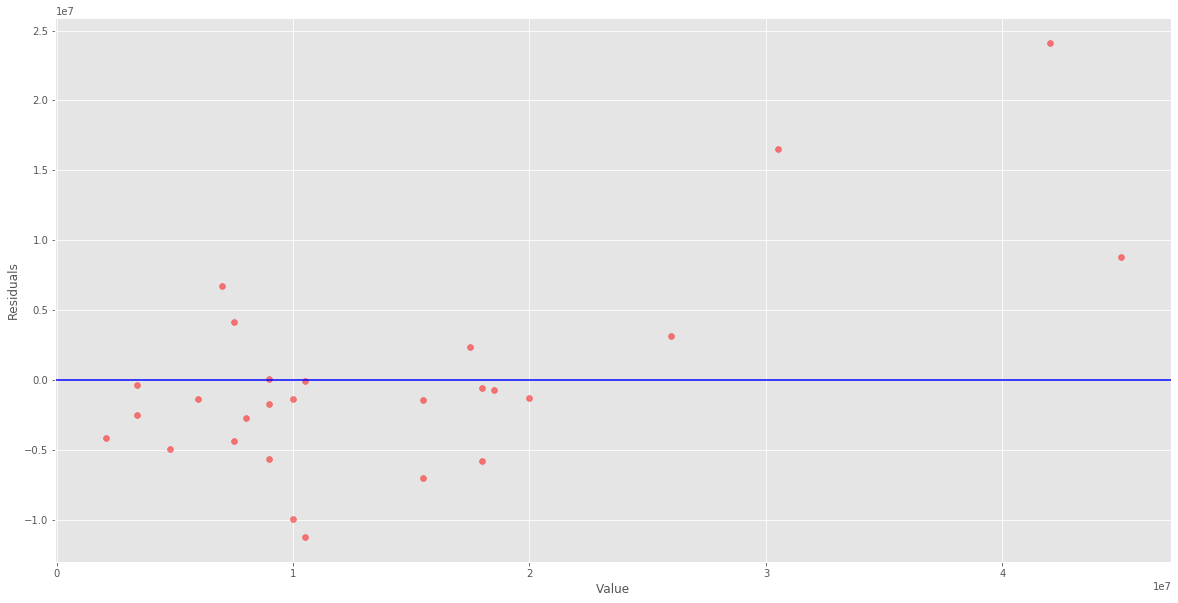

In [164]:
residuals = # ... FILL THIS LINE IN
print('Residuals: \n' + str(residuals) + '\n\n')

fig = plt.figure()
plt.scatter(y, residuals, color='red', alpha=0.8)
plt.axhline(y=0, color='b', linestyle='-', alpha=0.4)   # Horizontal line centered at 0

plt.xlabel('Overall')
plt.ylabel('Residuals')
plt.title('Residual Plot for Overall vs. Finishing')
plt.show()

### Do your residuals make sense? 

Again, discuss with a neighbor. If you have any questions - now is the time to ask!

# Finding Undervalued Players:

Let's inspect the players that our model felt most confident fitting. We can do that by selecting the players whose features had the smallest residuals, or the least error.

In [24]:
residuals = pd.DataFrame(data = residuals)
least_error = residuals.where((residuals < 1) & (residuals > -1)).dropna()

In [25]:
indxs = list(least_error.index)
print(indxs)

[87, 268, 381, 430, 560, 1237, 1347, 1386, 1404, 2936, 3210]


In [26]:
final_cuts = fifa_df.iloc[indxs]

In [28]:
final_cuts[['Name', 'Value', 'Age']]

,Name,Value,Age
87,A. Lacazette,45000000.0,27
268,C. Bakambu,26000000.0,27
381,F. Smolov,18500000.0,28
430,Mariano,20000000.0,24
560,Richarlison,18000000.0,21
1237,E. Boateng,10500000.0,22
1347,A. Gray,9000000.0,27
1386,M. Konaté,10000000.0,25
1404,E. Valencia,8000000.0,28
2936,O. Edouard,7000000.0,20


In [27]:
final_cuts[features]

,Acceleration,SprintSpeed,Agility,Stamina,Strength,Height,Finishing
87,81.0,84.0,85.0,79.0,73.0,69,88.0
268,88.0,88.0,80.0,79.0,76.0,72,84.0
381,88.0,85.0,75.0,74.0,75.0,74,84.0
430,84.0,85.0,79.0,81.0,79.0,71,81.0
560,83.0,85.0,78.0,78.0,76.0,71,79.0
1237,89.0,88.0,89.0,79.0,72.0,69,75.0
1347,87.0,87.0,75.0,72.0,75.0,71,75.0
1386,84.0,88.0,79.0,71.0,74.0,72,76.0
1404,88.0,87.0,80.0,80.0,74.0,70,75.0
2936,88.0,82.0,72.0,72.0,76.0,74,73.0
